In [28]:
import os
import uuid
import dotenv
from typing import List, Dict, Any

from langchain.chat_models import init_chat_model
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain.agents import create_agent

from langgraph.checkpoint.memory import MemorySaver

from transformers import logging
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from langchain_openai import ChatOpenAI

import numpy as np
import matplotlib.pyplot as plt


C:\Users\igors\AppData\Local\Temp\ipykernel_4492\298470595.py:19: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
C:\Users\igors\AppData\Local\Temp\ipykernel_4492\298470595.py:19: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
C:\Users\igors\AppData\Local\Temp\ipykernel_4492\298470595.py:19: DeprecationWarning: Importing context_precision from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ra

In [5]:
logging.set_verbosity_error()

dotenv.load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1")

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2", "true")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT", "rag-sael")

In [6]:
model = init_chat_model(
    model=os.getenv("OPEN_MODEL", "openai-gpt-oss-120b"),
    model_provider="openai",
    base_url=os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1")
)

In [7]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vector_store = InMemoryVectorStore(embeddings)

In [8]:
loader = DirectoryLoader(
    path="docs",
    glob="**/*.pdf",
    loader_cls=PyPDFLoader
)

docs = loader.load()

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

all_splits = text_splitter.split_documents(docs)

document_ids = vector_store.add_documents(documents=all_splits)

In [10]:
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = [retrieve_context]

In [11]:
prompt = (
    "You have access to a tool that retrieves context from a book for logic programming. "
    "Use the tool to help answer user queries."
    "Responda sempre em português, mesmo que a pergunta seja feita em outro idioma."
)

In [12]:
checkpointer = MemorySaver()

In [13]:
agent = create_agent(
    model, 
    tools, 
    system_prompt=prompt,
    checkpointer=checkpointer
)

In [14]:
test_queries = [
    "O que é lógica proposicional segundo a apostila?",
    "Como a apostila define uma proposição?",
    "O que são conectivos lógicos e quais são apresentados no material?",
    "O que é uma tabela-verdade e para que ela é utilizada?",
    "Como a apostila define tautologia, contradição e contingência?"
]

ground_truths = [
    "Lógica proposicional é o ramo da lógica que estuda proposições e as relações entre elas por meio de conectivos lógicos.",
    "Proposição é toda sentença declarativa que pode ser classificada como verdadeira ou falsa, mas não ambas.",
    "Conectivos lógicos são operadores que conectam proposições, como negação (¬), conjunção (∧), disjunção (∨), condicional (→) e bicondicional (↔).",
    "Tabela-verdade é um método utilizado para determinar o valor lógico de proposições compostas a partir dos valores lógicos das proposições simples.",
    "Tautologia é uma proposição composta que é sempre verdadeira; contradição é sempre falsa; contingência é aquela que pode ser verdadeira ou falsa dependendo dos valores das proposições componentes."
]

In [15]:
def run_agent_and_collect_data(query: str, ground_truth: str) -> Dict[str, Any]:
    thread_id = str(uuid.uuid4())
    
    events = list(agent.stream(
        {"messages": [{"role": "user", "content": query}]},
        config={"configurable": {"thread_id": thread_id}},
        stream_mode="values",
    ))
    
    final_event = events[-1]
    answer = final_event["messages"][-1].content

    retrieved_docs = vector_store.similarity_search(query, k=2)
    contexts = [doc.page_content for doc in retrieved_docs]
    
    return {
        "question": query,
        "contexts": contexts,
        "answer": answer,
        "ground_truth": ground_truth
    }

In [17]:
def evaluate_with_ragas():
    print("Executando agent para coletar dados de teste...")
    ragas_data = []
    
    for i, query in enumerate(test_queries):
        print(f"Testando: {query}")
        data_point = run_agent_and_collect_data(query, ground_truths[i])
        ragas_data.append(data_point)
    
    test_dataset = Dataset.from_list(ragas_data)
    
    print("\nExecutando avaliação RAGAS...")

    eval_llm = ChatOpenAI(
        model=os.getenv("OPEN_MODEL", "openai-gpt-oss-120b"),
        base_url=os.getenv("OPEN_API_URL", "https://inference.do-ai.run/v1"),
        temperature=0
    )
    
    result = evaluate(
        test_dataset,
        metrics=[faithfulness, answer_relevancy, context_precision, context_recall],
        llm=eval_llm,
        embeddings=embeddings 
    )
    
    print("\n=== RESULTADOS RAGAS ===")
    print(result)
    
    df = result.to_pandas()
    print("\nDetalhes por query:")
    print(df)
    
    return result

In [18]:
ragas_result = evaluate_with_ragas()

Executando agent para coletar dados de teste...
Testando: O que é lógica proposicional segundo a apostila?
Testando: Como a apostila define uma proposição?
Testando: O que são conectivos lógicos e quais são apresentados no material?
Testando: O que é uma tabela-verdade e para que ela é utilizada?
Testando: Como a apostila define tautologia, contradição e contingência?

Executando avaliação RAGAS...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x000002110FACE400> is already entered
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating:   5%|▌         | 1/20 [00:04<01:33,  4.91s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 20/20 [00:54<00:00,  2.70s/it]



=== RESULTADOS RAGAS ===
{'faithfulness': 0.5116, 'answer_relevancy': 0.6122, 'context_precision': 0.8000, 'context_recall': 0.8000}

Detalhes por query:
                                          user_input  \
0   O que é lógica proposicional segundo a apostila?   
1             Como a apostila define uma proposição?   
2  O que são conectivos lógicos e quais são apres...   
3  O que é uma tabela-verdade e para que ela é ut...   
4  Como a apostila define tautologia, contradição...   

                                  retrieved_contexts  \
0  [Apostila de Lógica de Programação \nProf. Wal...   
1  [Apostila de Lógica de Programação \nProf. Wal...   
2  [Apostila de Lógica de Programação \nProf. Wal...   
3  [a verdade e não cuida da própria verdade. Ela...   
4  [Tautologia - denomina-se tautologia a proposi...   

                                            response  \
0  **Lógica proposicional – definição segundo a a...   
1  A apostila de **Lógica de Programação** (Prof....   
2  

In [ ]:
df_results = ragas_result.to_pandas()

metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']
available_metrics = [m for m in metrics if m in df_results.columns]
mean_scores = [df_results[m].mean() for m in available_metrics]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(available_metrics)))

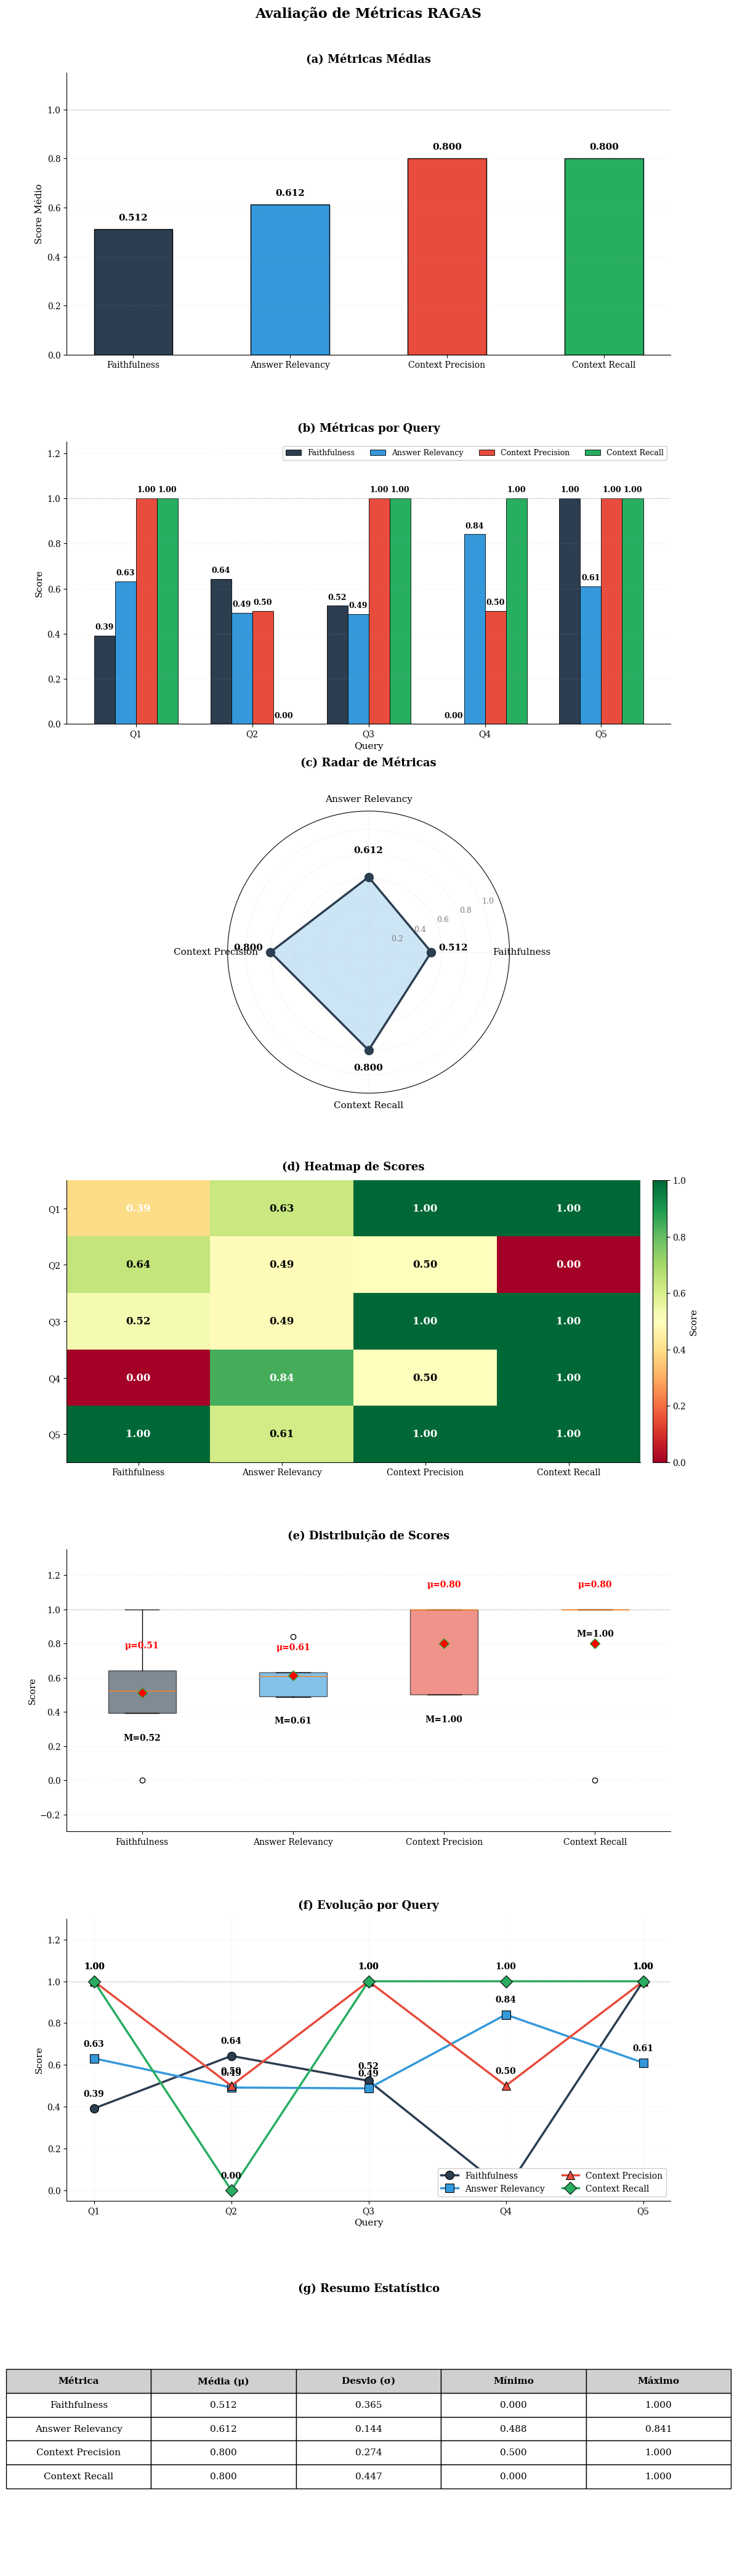

In [40]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']
metric_labels = ['Faithfulness', 'Answer Relevancy', 'Context Precision', 'Context Recall']
available_metrics = [m for m in metrics if m in df_results.columns]
available_labels = [metric_labels[i] for i, m in enumerate(metrics) if m in df_results.columns]

if not available_metrics:
    raise ValueError("Nenhuma métrica esperada foi encontrada em df_results.")

plot_df = df_results[available_metrics].apply(lambda col: col.astype(float)).copy()
mean_scores = plot_df.mean().tolist()
n_queries = len(plot_df)

colors = ['#2c3e50', '#3498db', '#e74c3c', '#27ae60'][:len(available_metrics)]

fig = plt.figure(figsize=(12, 42))
fig.suptitle("Avaliação de Métricas RAGAS", fontsize=16, fontweight='bold', y=0.995)

ax1 = fig.add_subplot(7, 1, 1)
bars = ax1.bar(range(len(available_metrics)), mean_scores, color=colors, edgecolor='black', linewidth=1, width=0.5)
ax1.set_title("(a) Métricas Médias", fontweight='bold', pad=12)
ax1.set_ylabel("Score Médio")
ax1.set_ylim(0, 1.15)
ax1.set_xticks(range(len(available_metrics)))
ax1.set_xticklabels(available_labels)
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.grid(axis='y', linestyle=':', alpha=0.4)

for i, (bar, score) in enumerate(zip(bars, mean_scores)):
    ax1.text(bar.get_x() + bar.get_width()/2, score + 0.03, f'{score:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = fig.add_subplot(7, 1, 2)
x = np.arange(n_queries)
width = 0.18
multiplier = 0

for i, (metric, label) in enumerate(zip(available_metrics, available_labels)):
    offset = width * multiplier
    rects = ax2.bar(x + offset, plot_df[metric].values, width, label=label,
                    color=colors[i], edgecolor='black', linewidth=0.6)
    
    for rect, val in zip(rects, plot_df[metric].values):
        height = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2, height + 0.02, f'{val:.2f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    multiplier += 1

ax2.set_title("(b) Métricas por Query", fontweight='bold', pad=12)
ax2.set_xlabel("Query")
ax2.set_ylabel("Score")
ax2.set_xticks(x + width * (len(available_metrics) - 1) / 2)
ax2.set_xticklabels([f"Q{i+1}" for i in range(n_queries)])
ax2.set_ylim(0, 1.25)
ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.legend(loc='upper right', frameon=True, framealpha=0.95, fontsize=9, ncol=4)
ax2.grid(axis='y', linestyle=':', alpha=0.4)

ax3 = fig.add_subplot(7, 1, 3, projection='polar')

angles = np.linspace(0, 2 * np.pi, len(available_metrics), endpoint=False).tolist()
angles += angles[:1]
radar_values = mean_scores + [mean_scores[0]]

ax3.plot(angles, radar_values, color='#2c3e50', linewidth=2.5, marker='o', markersize=10)
ax3.fill(angles, radar_values, color='#3498db', alpha=0.25)

# Labels com valores
for angle, value, label in zip(angles[:-1], mean_scores, available_labels):
    ax3.annotate(f'{value:.3f}', xy=(angle, value), xytext=(angle, value + 0.18),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(available_labels, fontsize=11)
ax3.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax3.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9, color='gray')
ax3.set_ylim(0, 1.15)
ax3.set_title("(c) Radar de Métricas", fontweight='bold', pad=20, y=1.1)
ax3.grid(True, linestyle=':', alpha=0.5)

ax4 = fig.add_subplot(7, 1, 4)
heatmap_data = plot_df.values
im = ax4.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

ax4.set_title("(d) Heatmap de Scores", fontweight='bold', pad=12)
ax4.set_xticks(np.arange(len(available_metrics)))
ax4.set_xticklabels(available_labels)
ax4.set_yticks(np.arange(n_queries))
ax4.set_yticklabels([f"Q{i+1}" for i in range(n_queries)])

for i in range(n_queries):
    for j in range(len(available_metrics)):
        val = heatmap_data[i, j]
        text_color = 'white' if val < 0.4 or val > 0.75 else 'black'
        ax4.text(j, i, f"{val:.2f}", ha='center', va='center',
                 color=text_color, fontsize=12, fontweight='bold')

cbar = fig.colorbar(im, ax=ax4, fraction=0.03, pad=0.02)
cbar.set_label("Score", fontsize=11)
cbar.ax.tick_params(labelsize=10)

ax5 = fig.add_subplot(7, 1, 5)
box_data = [plot_df[m].dropna().values for m in available_metrics]
bp = ax5.boxplot(box_data, labels=available_labels, patch_artist=True, 
                  showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markersize': 8})

for i, (patch, color) in enumerate(zip(bp['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

for i, data in enumerate(box_data):
    mean_val = np.mean(data)
    median_val = np.median(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    ax5.text(i + 1, q3 + 0.12, f'μ={mean_val:.2f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold', color='red')

    ax5.text(i + 1, q1 - 0.12, f'M={median_val:.2f}', ha='center', va='top', 
             fontsize=10, color='black', fontweight='bold')

ax5.set_title("(e) Distribuição de Scores", fontweight='bold', pad=12)
ax5.set_ylabel("Score")
ax5.set_ylim(-0.3, 1.35)
ax5.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax5.grid(axis='y', linestyle=':', alpha=0.4)

ax6 = fig.add_subplot(7, 1, 6)
markers = ['o', 's', '^', 'D']

for i, (metric, label) in enumerate(zip(available_metrics, available_labels)):
    line, = ax6.plot(x, plot_df[metric], marker=markers[i], label=label,
                     color=colors[i], linewidth=2.5, markersize=10, markeredgecolor='black', markeredgewidth=0.8)
    # Adiciona valores em cada ponto
    for xi, val in zip(x, plot_df[metric]):
        ax6.annotate(f'{val:.2f}', xy=(xi, val), xytext=(0, 12), textcoords='offset points',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

ax6.set_title("(f) Evolução por Query", fontweight='bold', pad=12)
ax6.set_xlabel("Query")
ax6.set_ylabel("Score")
ax6.set_xticks(x)
ax6.set_xticklabels([f"Q{i+1}" for i in range(n_queries)])
ax6.set_ylim(-0.05, 1.3)
ax6.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax6.legend(loc='lower right', frameon=True, framealpha=0.95, fontsize=10, ncol=2)
ax6.grid(linestyle=':', alpha=0.4)

ax7 = fig.add_subplot(7, 1, 7)
ax7.axis('off')

desc = plot_df.describe().loc[['mean', 'std', 'min', 'max']].round(3)

# Criar tabela
table_data = []
table_data.append(['Métrica', 'Média (μ)', 'Desvio (σ)', 'Mínimo', 'Máximo'])
for m, label in zip(available_metrics, available_labels):
    table_data.append([
        label,
        f'{desc.loc["mean", m]:.3f}',
        f'{desc.loc["std", m]:.3f}',
        f'{desc.loc["min", m]:.3f}',
        f'{desc.loc["max", m]:.3f}'
    ])

table = ax7.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center',
    colColours=['#f0f0f0'] * 5,
    cellColours=[['white'] * 5 for _ in range(len(available_metrics))]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Estilizar cabeçalho
for i in range(5):
    table[(0, i)].set_text_props(fontweight='bold')
    table[(0, i)].set_facecolor('#d0d0d0')

ax7.set_title("(g) Resumo Estatístico", fontweight='bold', pad=12, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()